In [ ]:
!nvidia-smi

Mon Jul 11 09:00:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 12447, done.
remote: Total 12447 (delta 0), reused 0 (delta 0), pack-reused 12447
Receiving objects: 100% (12447/12447), 12.21 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (8591/8591), done.
/content/yolov5/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 31.3 MB/s 
Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
%cd /content
!curl -L "https://app.roboflow.com/ds/CeD7iquLpf?key=lcioQwKsbw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   1864      0 --:--:-- --:--:-- --:--:--  1864
100 1830k  100 1830k    0     0  1491k      0  0:00:01  0:00:01 --:--:-- 1491k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/120_jpg.rf.7ae39cf408f1edede20011a5386aad63.jpg  
 extracting: test/images/132_jpg.rf.73cb24db686c6ae18848dd3deaf9979f.jpg  
 extracting: test/images/138_jpg.rf.d4df53dd5aab4f0c16abfc3359b8f6ea.jpg  
 extracting: test/images/141_jpg.rf.d5d8d68e00850278415b44e9783ee083.jpg  
 extracting: test/images/2bxf73h_jpg.rf.3542295fac2299aabd6b2a27e5a8bcba.jpg  
 extracting: test/images/2ckghhj_jpg.rf.742afccffc188a5ff2a78ba75f34eb9b.jpg  
 extracting: test/images/AnyConv-co

In [ ]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['Health Apple', 'Sick Apple']

In [ ]:
import yaml
with open("data.yaml", 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
      f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml
# parametersnc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
# anchors
anchors:
- [10,13, 16,30, 33,23] # P3/8
- [30,61, 62,45, 59,119] # P4/16
- [116,90, 156,198, 373,326] # P5/32
# YOLOv5 backbone
backbone:
# [from, number, module, args]
[[-1, 1, Focus, [64, 3]], # 0-P1/2
[-1, 1, Conv, [128, 3, 2]], # 1-P2/4
[-1, 3, BottleneckCSP, [128]],
[-1, 1, Conv, [256, 3, 2]], # 3-P3/8
[-1, 9, BottleneckCSP, [256]],
[-1, 1, Conv, [512, 3, 2]], # 5-P4/16
[-1, 9, BottleneckCSP, [512]],
[-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
[-1, 1, SPP, [1024, [5, 9, 13]]],
[-1, 3, BottleneckCSP, [1024, False]], # 9
]
# YOLOv5 head
head:
[[-1, 1, Conv, [512, 1, 1]],
[-1, 1, nn.Upsample, [None, 2, 'nearest']],
[[-1, 6], 1, Concat, [1]], # cat backbone P4
[-1, 3, BottleneckCSP, [512, False]], # 13
[-1, 1, Conv, [256, 1, 1]],
[-1, 1, nn.Upsample, [None, 2, 'nearest']],
[[-1, 4], 1, Concat, [1]], # cat backbone P3
[-1, 3, BottleneckCSP, [256, False]], # 17 (P3/8-small)
[-1, 1, Conv, [256, 3, 2]],
[[-1, 14], 1, Concat, [1]], # cat head P4
[-1, 3, BottleneckCSP, [512, False]], # 20 (P4/16-medium)
[-1, 1, Conv, [512, 3, 2]],
[[-1, 10], 1, Concat, [1]], # cat head P5
[-1, 3, BottleneckCSP, [1024, False]], # 23 (P5/32-large)
[[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
]

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 32 --epochs 150 --data '../data.yaml' --cfg ./models/yolov5s.yaml --weights '../yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
github: ⚠️ WARNING: code is out of date by 1149 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=32, bucket='', cache_images=True, cfg='./models/yolov5s.yaml', data='../data.yaml', device='', entity=None, epochs=150, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results', single_cls=False, sync_bn=False, total_batch_size=32, weights='../yolov5s.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboar

In [ ]:
%cd /content/yolov5/
!python test.py --img 416 --batch 16 --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --data /content/data.yaml

/content/yolov5
Namespace(augment=False, batch_size=16, conf_thres=0.001, data='/content/data.yaml', device='', exist_ok=False, img_size=416, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
val: Scanning '../valid/labels.cache' for images and labels... 15 found, 0 missing, 0 empty, 0 corrupted: 100% 15/15 [00:00<?, ?it/s]
             

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/apelsehat.jpeg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/1 /content/apelsehat.jpeg: 256x256 1 Health Apple, Done. (0.015s)
Results saved to runs/detect/exp
Done. (0.049s)


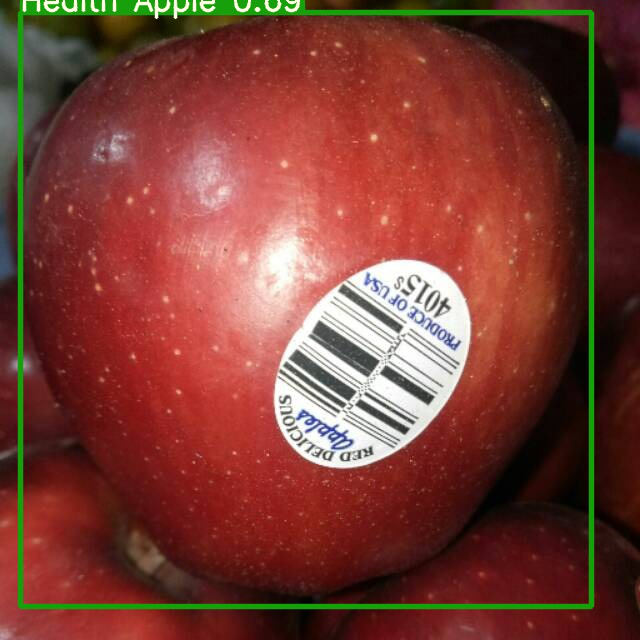

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/apelsehat.jpeg
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp/apelsehat.jpeg')

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/apelsehat.png', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/1 /content/apelsehat.png: 160x256 2 Health Apples, Done. (0.042s)
Results saved to runs/detect/exp
Done. (0.084s)


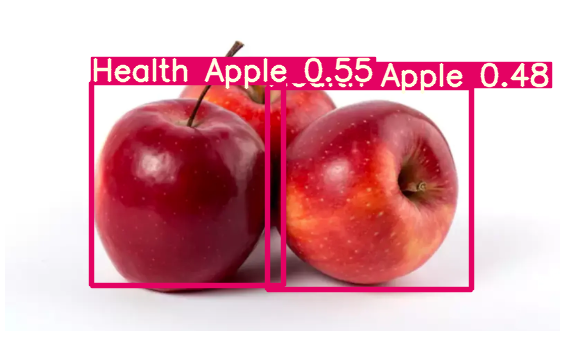

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/apelsehat.png
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp/apelsehat.png')

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/random.jpg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/1 /content/random.jpg: 160x256 4 Health Apples, Done. (0.043s)
Results saved to runs/detect/exp3
Done. (0.074s)


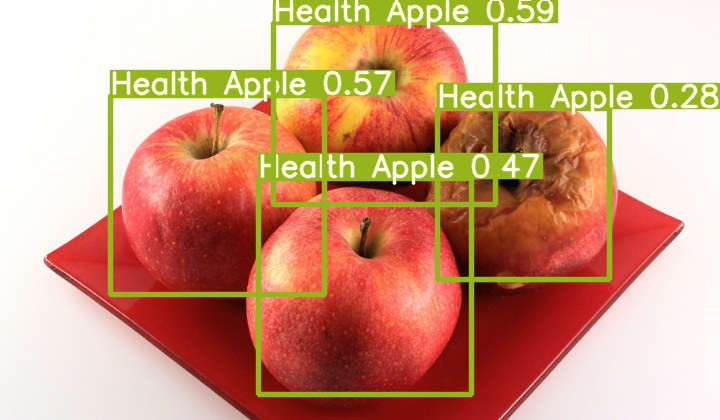

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/random.jpg
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp3/random.jpg')

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/blur2.jpeg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/1 /content/blur2.jpeg: 256x256 1 Health Apple, Done. (0.015s)
Results saved to runs/detect/exp12
Done. (0.020s)


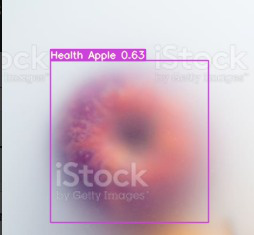

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/blur2.jpeg
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp12/blur2.jpeg')

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/apelbusuk.jpg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/1 /content/apelbusuk.jpg: 256x256 1 Sick Apple, Done. (0.019s)
Results saved to runs/detect/exp3
Done. (0.057s)


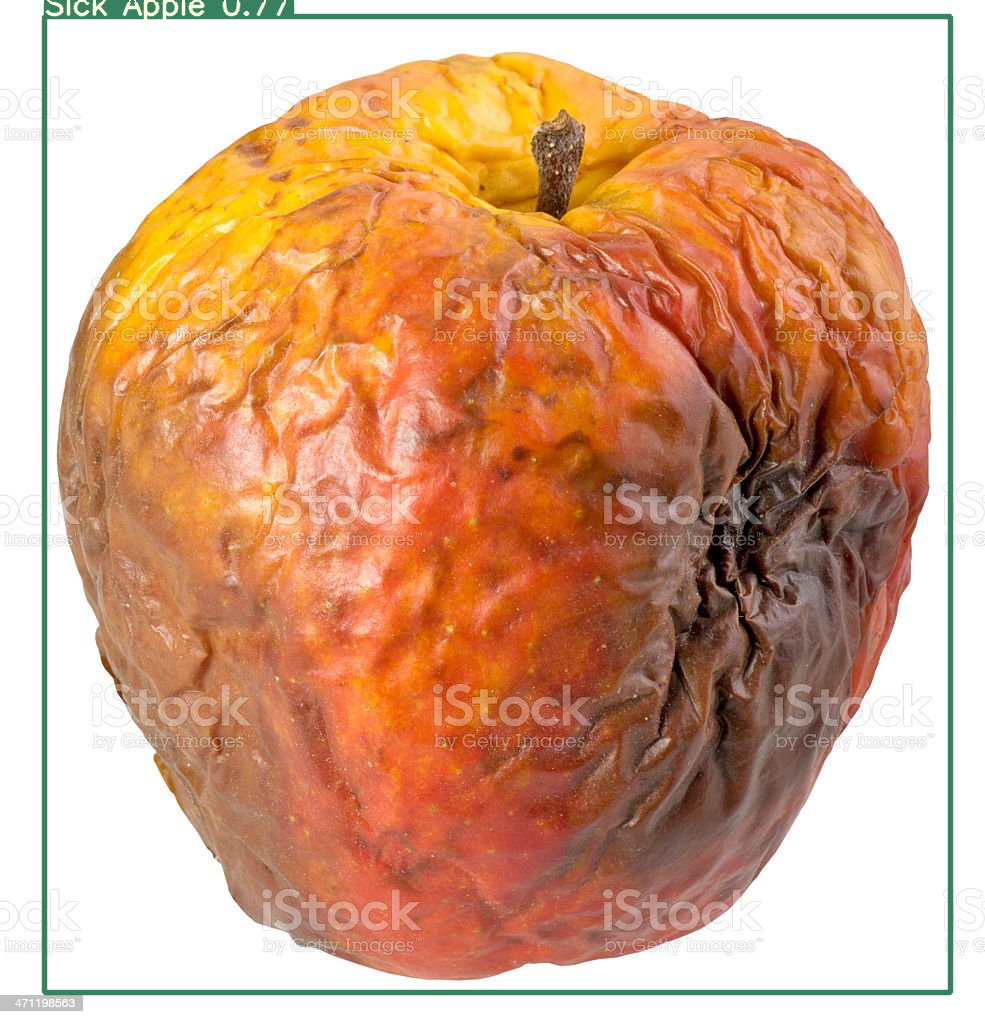

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/apelbusuk.jpg
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp3/apelbusuk.jpg')

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/Pepper_bac.JPG', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPS
image 1/1 /content/Pepper_bac.JPG: 256x256 1 Bacterial_Pepper, Done. (0.020s)


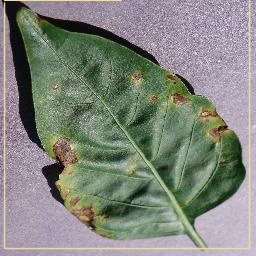

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/Pepper_bac.JPG
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp6/Pepper_bac.JPG')

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/pepper_helth.JPG', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPS
image 1/1 /content/pepper_helth.JPG: 256x256 1 Healthy_Pepper, Done. (0.021s

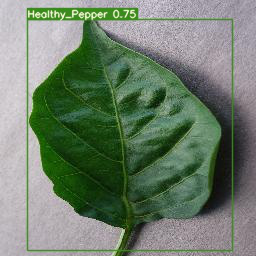

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/pepper_helth.JPG
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp7/pepper_helth.JPG')